In [1]:
# dependencies import
from common_dependencies import *
from typing import NamedTuple
#import model_versions as mv
import logging
logger = logging.getLogger(f'main.model_train')
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)
DataCrop = NamedTuple("DataCrop", [('left', int), ('top', int), ('width', int), ('height', int)])
DatasetPartDescription = NamedTuple("DatasetPartDescription", [('run_name', str), ('data_crop', DataCrop)])

2024-04-25 19:12:44.108135: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-04-25 19:12:44.145914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 19:12:44.554052: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# train params that can be easily changed
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

MAX_VAL = 1000
PATH_TO_MODEL = 'networks/AE'
#RUNS = [2, 1]
MODEL_VER = '01'
MODEL_NUM = '01'
XSHIFT = 200

for name in os.listdir(PATH_TO_MODEL):
    res = re.match(F'(id=v{MODEL_VER}n{MODEL_NUM}).*', name)
    if not res is None:
        PATH_TO_MODEL += '/' + res[0]
        break

file_1_dataset_desc = (DatasetPartDescription('run_1', DataCrop(0,0,MAX_VAL,MAX_VAL)),)
file_2_dataset_desc = (DatasetPartDescription('run_2', DataCrop(0,0,MAX_VAL,MAX_VAL)),)
#test_dataset_desc = (DatasetPartDescription('run_2', DataCrop(0,40,MAX_VAL,MAX_VAL)),)

In [3]:
#функция прикарманивания данных
def get_dataset_gen(path_to_data_tuple: tuple(),
                x_shift: int,
                data_part: DataCrop):
    logger.debug("start")

    # read data
    x_df, y_df = dw.get_x_and_y_data(*path_to_data_tuple)
    # roll data across x axis
    x_df = dw.roll_df(x_df, x_shift, 1)
    y_df = dw.roll_df(y_df, x_shift, 1)
    # slice certain data part
    x_df = x_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    y_df = y_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    # cast data from dataframe to numpy array
    x_arr = dw.df_to_numpy(x_df)
    y_arr = y_df.to_numpy()
    # normalize data
    x_arr = np.concatenate([dw.normalize_data(x_arr[:,:,:32]), dw.normalize_data(x_arr[:,:,32:])],axis=2)
    y_arr = dw.normalize_data(y_arr)
    # flat data from matrix of detector measures (64 values for each) to vector of measures
    x_arr = np.concatenate([row for row in x_arr], axis=0)
    y_arr = np.concatenate([row for row in y_arr], axis=0)
    
    logger.debug("end")

    return (x_arr, y_arr)

In [4]:
def concat_data_tuples(dataset_desc, xshift):
    # get output data tuple for each data part from dataset_desc
    data_tuples_arr = [get_dataset_gen(PATH_TO_DATA[desc_part.run_name], xshift, desc_part.data_crop) for desc_part in dataset_desc]
    # concat data tuples throught 1 axis (like concat every first item from all tuple into one first item of result tuple, same to second and etc.)
    # output tuple has the same quantity of values as every tuple got from previous step but each element of it is concatination of all elements
    # from that position from all read tuples
    return (*[np.concatenate(item,axis=0) for item in zip(*data_tuples_arr)],)

In [5]:
#входные и выходные данные
(file_1_x, file_1_y) = concat_data_tuples(file_1_dataset_desc, XSHIFT)
(file_2_x, file_2_y) = concat_data_tuples(file_2_dataset_desc, XSHIFT)

print('\nDatasets')
print(f'{file_1_x.shape=}, max={np.max(file_1_x)}, min={np.min(file_1_x)}')
print(f'{file_1_y.shape=}, max={np.max(file_1_y)}, min={np.min(file_1_y)}')
print()
print(f'{file_2_x.shape=}, max={np.max(file_2_x)}, min={np.min(file_2_x)}')
print(f'{file_2_y.shape=}, max={np.max(file_2_y)}, min={np.min(file_2_y)}')


Datasets
file_1_x.shape=(46000, 64), max=1.0, min=0.0
file_1_y.shape=(46000,), max=1.0, min=0.0

file_2_x.shape=(47600, 64), max=1.0, min=0.0
file_2_y.shape=(47600,), max=1.0, min=0.0


In [6]:
def1, nondef1 = file_1_x[file_1_y!=0], file_1_x[file_1_y==0] 
def2, nondef2 = file_2_x[file_2_y!=0], file_2_x[file_2_y==0] 

print(f'{def1.shape=}, {nondef1.shape=}')
print(f'{def2.shape=}, {nondef2.shape=}')

def1.shape=(522, 64), nondef1.shape=(45478, 64)
def2.shape=(508, 64), nondef2.shape=(47092, 64)


In [7]:
# Загрузка модели
ae = keras.models.load_model(PATH_TO_MODEL)

2024-04-25 19:12:51.987639: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 19:12:52.008967: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 19:12:52.009023: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 19:12:52.010583: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 19:12:52.010654: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [8]:
res_def_graphs1 = ae.predict(def1)  
res_nondef_graphs1 = ae.predict(nondef1)  

res_def_graphs2 = ae.predict(def2)   
res_nondef_graphs1 = ae.predict(nondef1)  

I0000 00:00:1714047172.412952   24303 service.cc:145] XLA service 0x7e0304006420 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714047172.412980   24303 service.cc:153]   StreamExecutor device (0): Radeon RX 7900 XT, AMDGPU ISA version: gfx1100


 1/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step

I0000 00:00:1714047175.191732   24303 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step


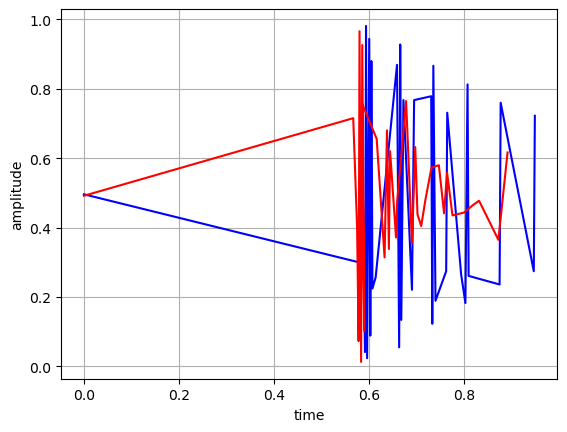

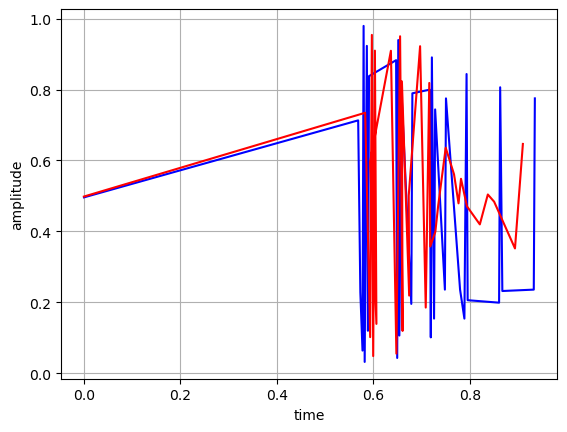

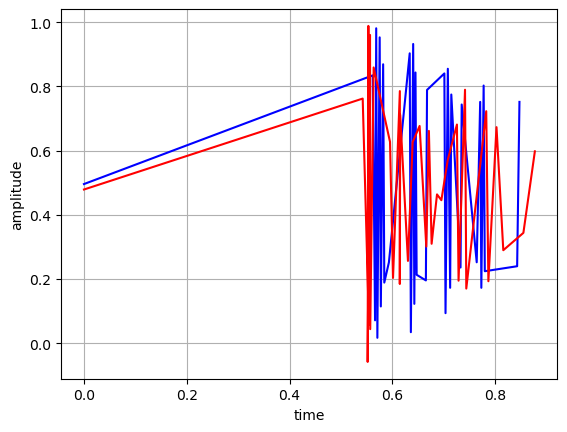

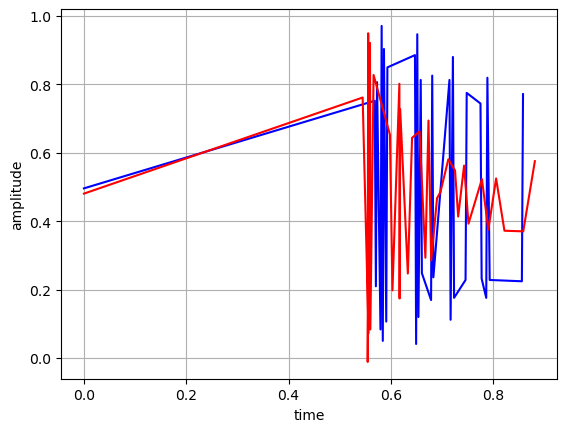

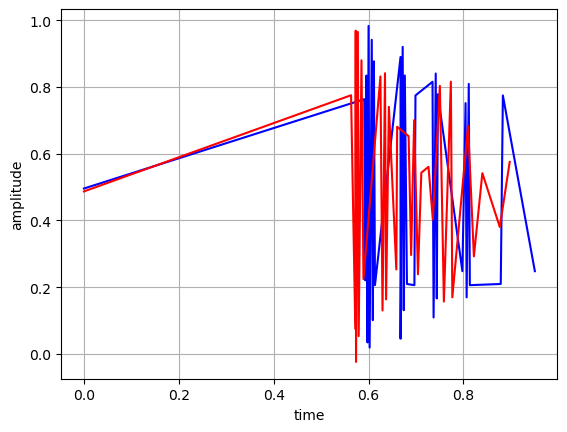

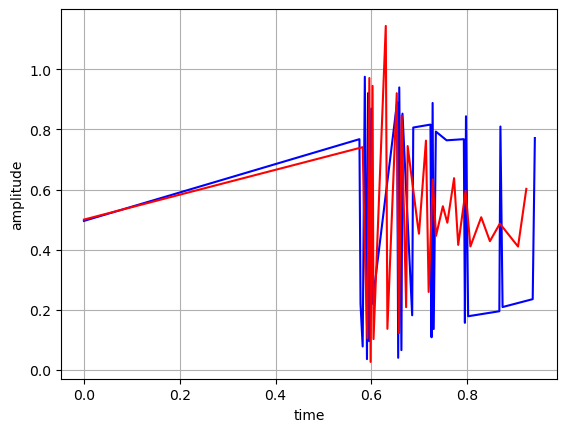

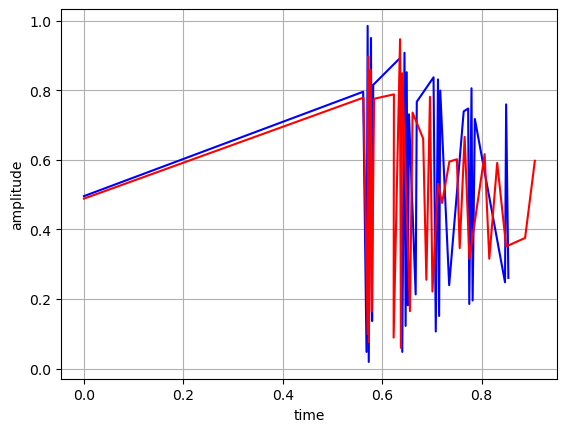

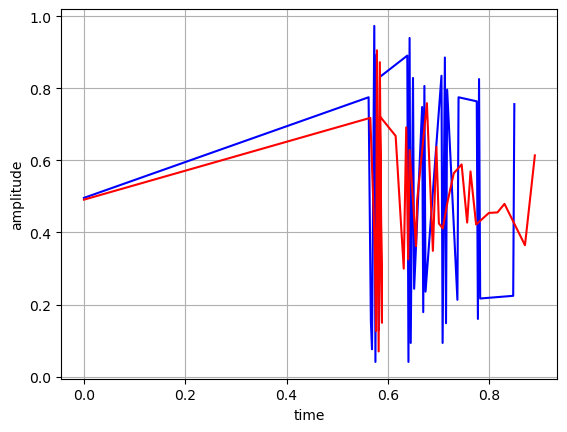

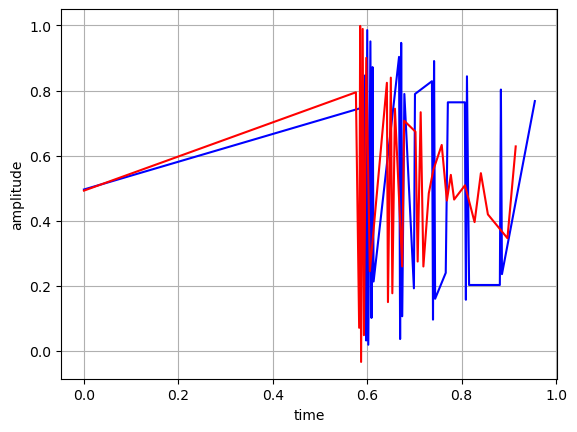

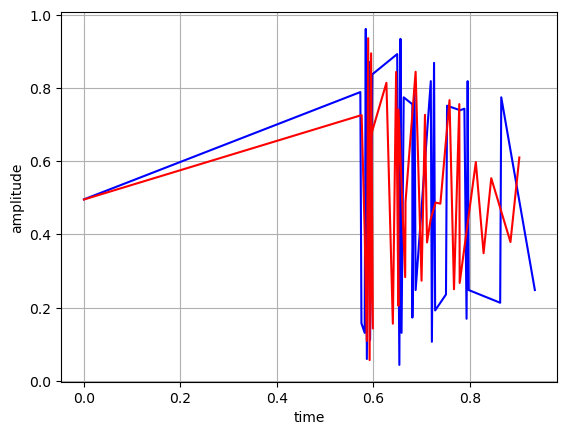

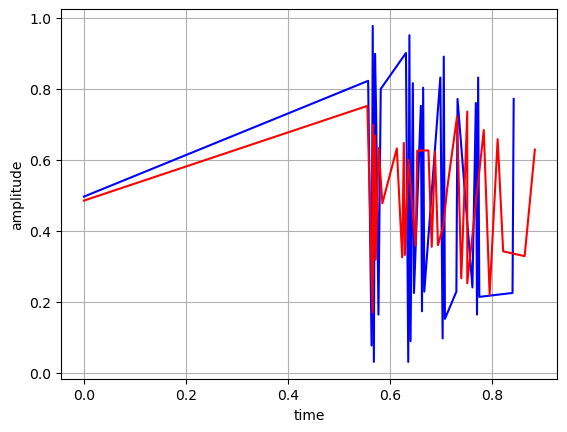

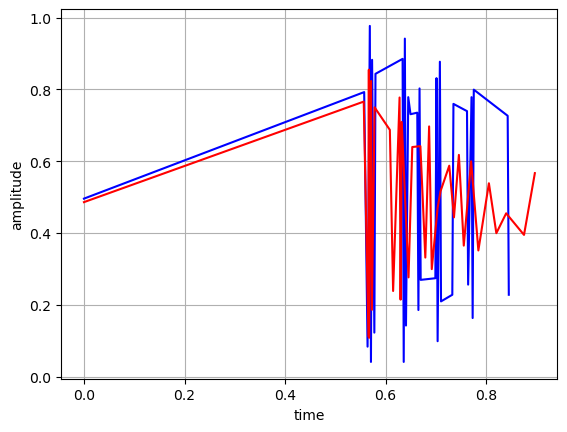

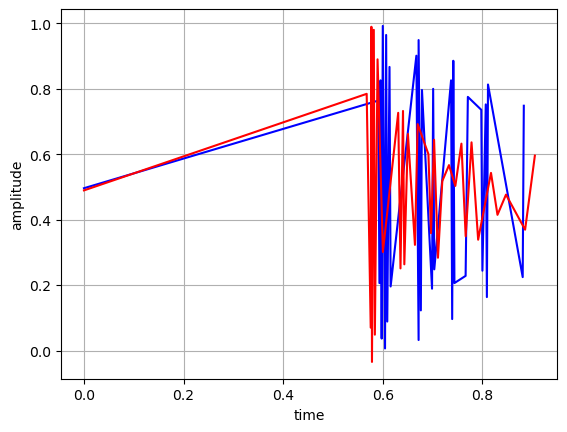

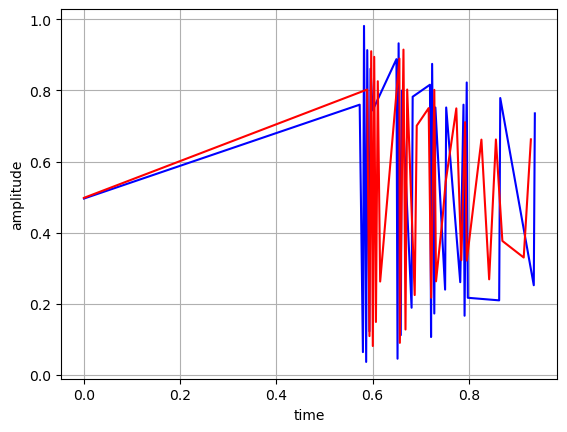

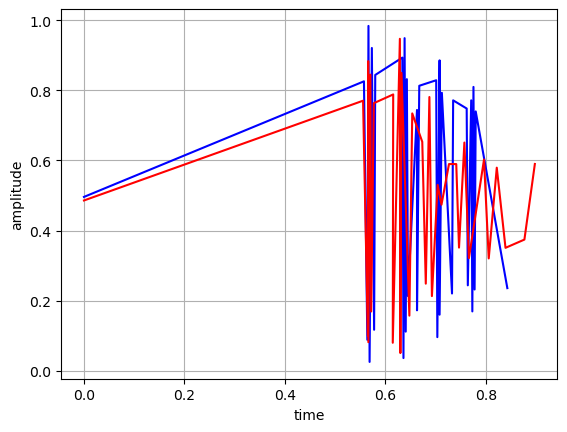

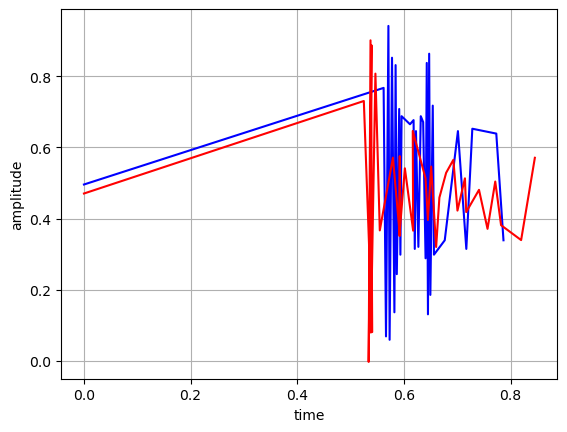

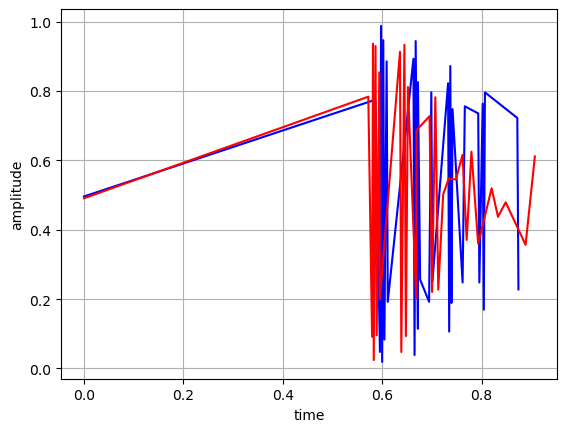

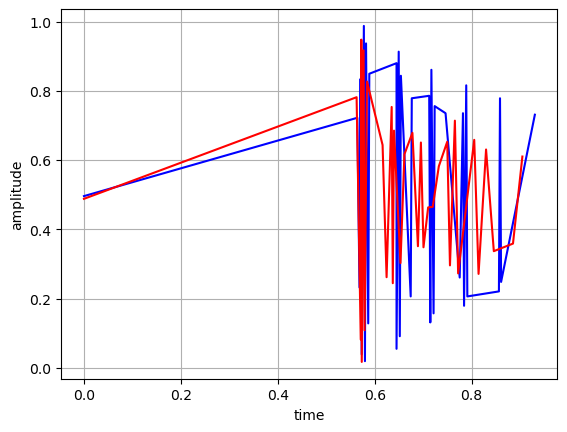

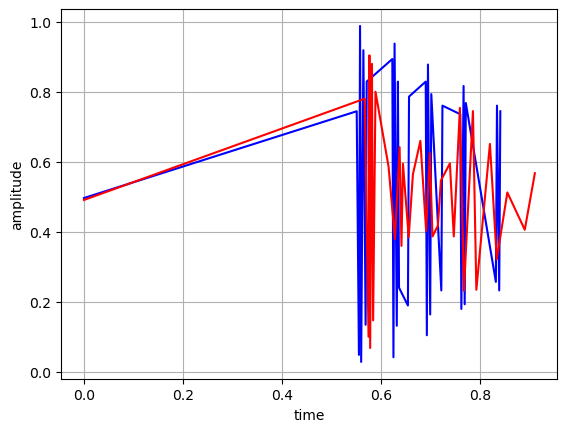

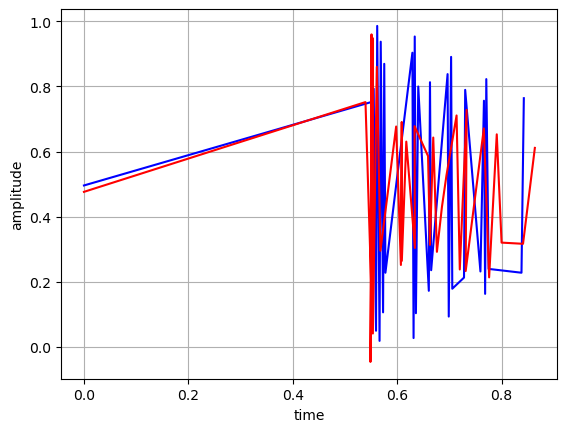

In [9]:
for i in range(20):
    plt.figure()
    
    plt.plot(nondef1[i,:32], nondef1[i,32:], c='blue')
    plt.plot(res_nondef_graphs1[i,:32], res_nondef_graphs1[i,32:], c='red')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.grid(True)
    plt.show()

#### 

In [10]:
# Предполагая, что у вас есть обученная модель ae
enc_model = keras.Model(inputs=ae.input, outputs=ae.get_layer('enc_output').output)  # Получение модели для вывода слоя enc_output
def_out1 = enc_model.predict(def1)  
nondef_out1 = enc_model.predict(nondef1) 
def_out2 = enc_model.predict(def2) 
nondef_out2 = enc_model.predict(nondef2) 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [11]:
print(def_out1.shape)
print(def_out1[:,0].shape)

(522, 4)
(522,)


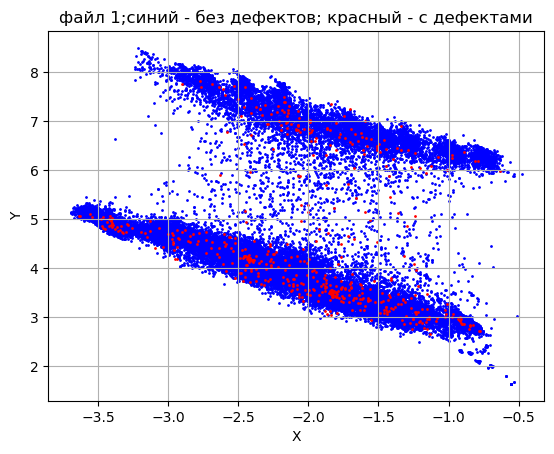

In [12]:
plt.figure()

plt.scatter(nondef_out1[:,0], nondef_out1[:,1],c='blue',s=1)
plt.scatter(def_out1[:,0], def_out1[:,1],c='red',s=1) 
plt.xlabel('X')
plt.ylabel('Y')
plt.title('файл 1;синий - без дефектов; красный - с дефектами')
plt.grid(True)
plt.show()

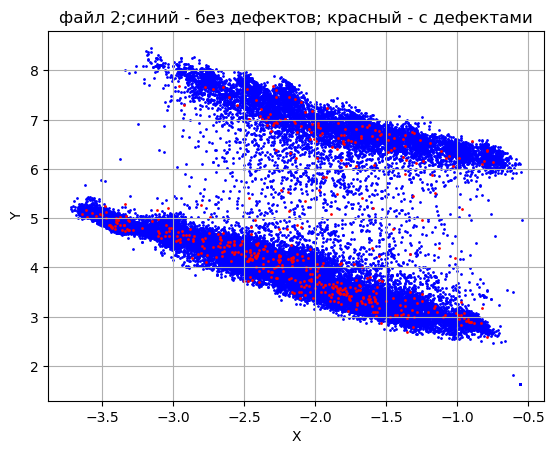

In [13]:
 plt.figure()

plt.scatter(nondef_out2[:,0], nondef_out2[:,1],c='blue',s=1)
plt.scatter(def_out2[:,0], def_out2[:,1],c='red',s=1) 
plt.xlabel('X')
plt.ylabel('Y')
plt.title('файл 2;синий - без дефектов; красный - с дефектами')
plt.grid(True)
plt.show()